# Uncertainty Analysis

This section demonstrates the use of the Monte Carlo sampling (MCS) method for forward propagation of uncertainty. In uncertainty analysis, it is of interest to quantify how uncertain design variables or parameters of a problem affect the quantity of interest (QoI) for a given system. This is done by sampling the distribution of the uncertain variables or parameters using a sampling method and calculating the QoI for a large number of samples. The required statistics (mean, standard deviation, reliability) can then be calculated from the QoI values that are generated using MCS. In the context of optimization, the statistics of interest are typically the mean and standard deviation of the objective function and the reliability of the constraint. 

To illustrate the ideas of uncertainty analysis, consider a problem with the following objective and constraint

$$Y = f(\textbf{x}) = x_1^2 + 2x_2^2 + 3x_3^2$$
$$g(\textbf{x}) = x_1 + x_2 + x_3 - 3.5 \leq 0$$

In this problem, $x_1$ is deterministic and other two variables are uncertain with standard deviations: $\sigma_2 = 0.06$ and $\sigma_3 = 0.2$. For the following analysis, the design variable values used are $x = [1,1,1]^T$. This means that $x_1 = 1$, $x_2 \sim \mathcal{N}(1,0.06)$, and $x_3 \sim \mathcal{N}(1, 0.2)$.

The first block of code below imports the required packages to perform the uncertainty analysis.

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm
from time import time
from smt.sampling_methods import LHS
from scipy.stats.qmc import Halton, scale
from pyDOE3 import lhs

## Calculation of statistics (mean and standard deviation) of objective function

The next block of code defines the objective function and constraint of the problem. 

In [3]:
def function(x1, x2, x3):
    """
        Function for computing objective values
    """
    
    value = x1**2 + 2*x2**2 + 3*x3**2
    
    return value

def constraint(x1, x2, x3):
    """
        Function for computing constraint values
    """

    value = x1 + x2 + x3 - 3.5

    return value

The first demonstration of MCS is with **random sampling**. The block of code below defines random variables for $x_2$ and $x_3$, and performs MCS with 500,000 random samples for computing mean, standard deviation, and the output distribution.

Estimated mean (true): 6.125690561704386
Estimated standard deviation (true): 1.2361330425932058


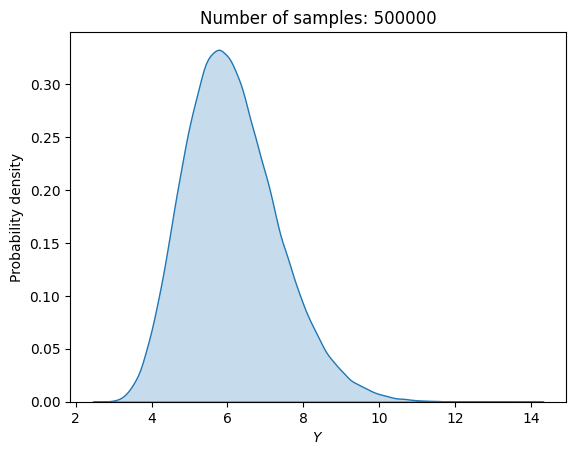

In [6]:
# Defining random variables
rv_x2 = norm(loc=1, scale=0.06)
rv_x3 = norm(loc=1, scale=0.2)
num_samples = 500000

x1 = 1
x2 = rv_x2.rvs(size=num_samples)
x3 = rv_x3.rvs(size=num_samples)

f = function(x1, x2, x3)

sns.kdeplot(x=f, fill=True)
plt.ylabel("Probability density")
plt.xlabel("$Y$")
plt.title("Number of samples: {}".format(num_samples))

print("Estimated mean (true): {}".format(np.mean(f)))
print("Estimated standard deviation (true): {}".format(np.std(f)))

From the above MCS with random sampling, the $\mu$ is 6.13 and $\sigma$ is 1.23. This distribution is slightly asymmetric and has a longer right tail. 

Now, MCS will be performed using **random sampling**, **Latin Hypercube sampling (LHS)** and **Halton sequences**. The previous analysis used a fixed number of samples to perform the MCS but in the following analysis, the number of samples used for the MCS will be varied and the statistics will be calculated at every number of samples. In this case, LHS and Halton sequences are used to generate samples between the bounds of 0 and 1. These values are treated as probabilities and the inverse CDF of the random variables is used to draw samples from the distribution based on the values of these probabilities.  

In [82]:
# Defining different samples sizes for MCS
samples = np.logspace(1.5, 4, 25, dtype=int)

# Defining the LHS sampler
lhs_sampler = LHS(xlimits=np.array([[0.0,1.0], [0.0,1.0]]), criterion="ese")

# Defining the Halton sampler
halton_sampler = Halton(d=2, scramble=False) 
# scramble is set to false to avoid Owen scrambling which is used to create non-deterministic Halton sequences

mean_lhs = []
sigma_lhs = []
mean_halton = []
sigma_halton = []
mean_random = []
sigma_random = []

for sample in samples:

    # LHS sampling
    x_lhs = lhs_sampler(sample)
    x2_lhs = rv_x2.ppf(x_lhs[:,0])
    x3_lhs = rv_x3.ppf(x_lhs[:,1])
    x1 = 1
    f_lhs = function(x1, x2_lhs, x3_lhs)
    mean_lhs.append(np.mean(f_lhs))
    sigma_lhs.append(np.std(f_lhs))

    # Halton sampling
    x_halton = halton_sampler.random(n = sample)
    x2_halton = rv_x2.ppf(x_halton[:,0])
    x3_halton = rv_x3.ppf(x_halton[:,1])
    f_halton = function(x1, x2_halton, x3_halton)
    mean_halton.append(np.mean(f_halton))
    sigma_halton.append(np.std(f_halton))
    
    # Random sampling
    x2 = rv_x2.rvs(size=sample)
    x3 = rv_x3.rvs(size=sample)
    f_random = function(x1, x2, x3)
    mean_random.append(np.mean(f_random))
    sigma_random.append(np.std(f_random))

/tmp/ipykernel_966168/3685018735.py:31: RuntimeWarning: invalid value encountered in scalar divide
  conv_mean_halton[i] = np.abs(mean_halton[i+1] - mean_halton[i]) / np.abs(mean_halton[0])


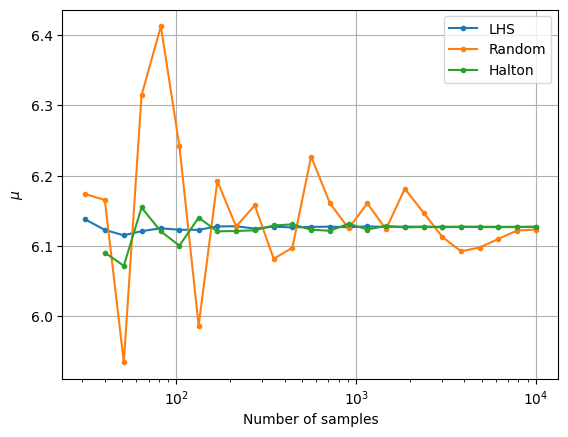

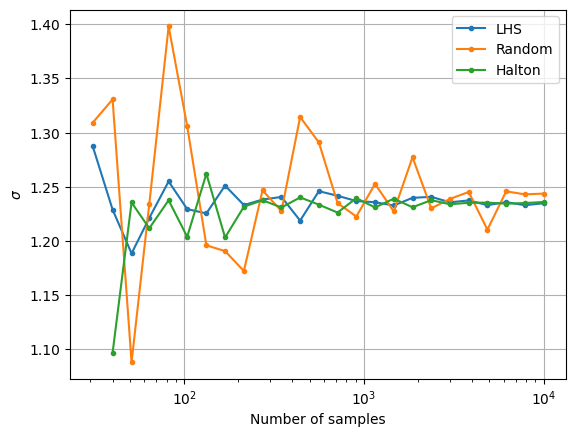

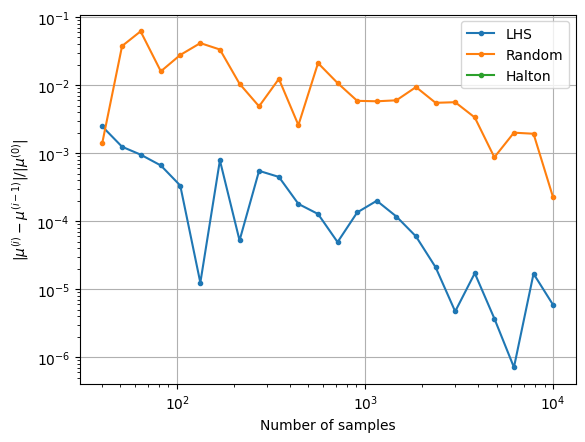

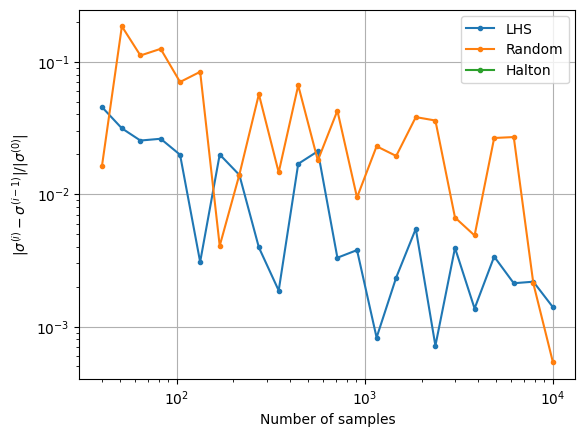

In [83]:
fig, ax = plt.subplots()
ax.plot(samples, mean_lhs, marker=".", label="LHS")
ax.plot(samples, mean_random, marker=".", label="Random")
ax.plot(samples, mean_halton, marker=".", label="Halton")
ax.legend()
ax.grid()
ax.set_ylabel("$\mu$")
ax.set_xlabel("Number of samples")
ax.set_xscale("log")

fig, ax = plt.subplots()
ax.plot(samples, sigma_lhs, marker=".", label="LHS")
ax.plot(samples, sigma_random, marker=".", label="Random")
ax.plot(samples, sigma_halton, marker=".", label="Halton")
ax.legend()
ax.grid()
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Number of samples")
ax.set_xscale("log")

conv_mean_lhs = np.zeros(len(samples)-1)
conv_mean_random = np.zeros(len(samples)-1)
conv_mean_halton = np.zeros(len(samples)-1)
conv_sigma_lhs = np.zeros(len(samples)-1)
conv_sigma_random = np.zeros(len(samples)-1)
conv_sigma_halton = np.zeros(len(samples)-1)

for i in range(len(samples)-1):
    conv_mean_lhs[i] = np.abs(mean_lhs[i+1] - mean_lhs[i]) / np.abs(mean_lhs[0])
    conv_mean_random[i] = np.abs(mean_random[i+1] - mean_random[i]) / np.abs(mean_random[0])
    conv_mean_halton[i] = np.abs(mean_halton[i+1] - mean_halton[i]) / np.abs(mean_halton[0])
    conv_sigma_lhs[i] = np.abs(sigma_lhs[i+1] - sigma_lhs[i]) / np.abs(sigma_lhs[0])
    conv_sigma_random[i] = np.abs(sigma_random[i+1] - sigma_random[i]) / np.abs(sigma_random[0])
    conv_sigma_halton[i] = np.abs(sigma_halton[i+1] - sigma_halton[i]) / np.abs(sigma_halton[0])
    
fig, ax = plt.subplots()
ax.plot(samples[1:], conv_mean_lhs, label="LHS", marker=".")
ax.plot(samples[1:], conv_mean_random, label="Random", marker=".")
ax.plot(samples[1:], conv_mean_halton, label="Halton", marker=".")
ax.legend()
ax.grid()
ax.set_ylabel("$ |\mu^{(i)} - \mu^{(i-1)}| / |\mu^{(0)}|$")
ax.set_xlabel("Number of samples")
ax.set_xscale("log")
ax.set_yscale("log")

fig, ax = plt.subplots()
ax.plot(samples[1:], conv_sigma_lhs, label="LHS", marker=".")
ax.plot(samples[1:], conv_sigma_random, label="Random", marker=".")
ax.plot(samples[1:], conv_sigma_halton, label="Halton", marker=".")
ax.legend()
ax.grid()
ax.set_ylabel("$ |\sigma^{(i)} - \sigma^{(i-1)}| / |\sigma^{(0)}|$")
ax.set_xlabel("Number of samples")
ax.set_xscale("log")
ax.set_yscale("log")

Notice that as the number of samples increase, the $\mu$ and $\sigma$ also converge to the value obtained from MCS in previous block.

## Reliability of a constraint